Install py-pde library

In [24]:
%pip install py-pde

Note: you may need to restart the kernel to use updated packages.


Generate dataset

## Basic Parameter Set

In [25]:
import numpy as np
import torch

f = 4410      # sampling frequency  
T = 1/f        # sampling time 
dur = 0.1       # simulation duration

t = np.arange(0, dur+T/2, T) # 0:T:dur;    # time vector 

l = 5          # length of the pipe 
dx = 1e-2      # spatial stepsize 
xs = np.arange(0, l+dx/2, dx) # 0:dx:l;    # space vector 
numXs = np.size(xs)

#c0 = 340
c0 = 30       # propagation speed

## FTM Stuff

In [26]:
Mu = 250       # number of eigenvalues 
mu = np.arange(1, Mu+1) # 1:Mu;    

test = 1j*c0*mu*np.pi/l

gmu = np.concatenate((mu*np.pi/l, mu*np.pi/l))
smu = np.concatenate((1j*c0*mu*np.pi/l, -1j*c0*mu*np.pi/l))

K1 = lambda x: 1j*np.sin(gmu*x) # @(x) 1j*sin(gmu*x); 
K2 = lambda x: 1j*smu*np.sin(gmu*x)
Ka1 = lambda x: 1j/c0**2*np.conj(smu)*np.sin(gmu*x)
Ka2 = lambda x: 1j*np.sin(gmu*x)

nmu = 1./(l/2*(c0**2*smu + np.conj(smu)))

A = np.diag(np.exp(smu*T)); 


In [97]:
xeVec = np.array([0.1*l, 0.2*l, 0.3*l]) # vector of excitaion positions (can be extended) 

num_param_steps = 1323
field_values = np.linspace(0,10,num_param_steps)
grid_size = numXs

training_input = torch.zeros(num_param_steps, grid_size,2)
training_output = torch.zeros(num_param_steps, grid_size,1)

# grid = CartesianGrid([[0, 1]], grid_size, periodic=False)

index = 0

for xe, xeVal in enumerate(xeVec): #for xe = 1:length(xeVec)
    # Excitation for the wave equation is a simple delta-impulse at
    # position xe
    # Possible extensions: 
    # - exciation by a hamming window to have a more smooth excitation 
    # - combination with a temporal exciation shape 
    yi = Ka2(xeVal)*T; # set initial values for states
    
    # vectors 
    ybar = np.zeros((2*Mu, np.size(t)),dtype=complex); 
    
    # set initial states
    ybar[:,0] = yi; 
    
    test = range(1,np.size(t))
    
    # processing to create time progression of individual states
    for k in range(1,np.size(t)) :
        ybar[:,k] = A@ybar[:,k-1]
    
    
    # create output signal over time at a single observation position
    # (maybe this part is not necessary, therefore it is commented)
    xo = 0.7*l; 
    c1 = K1(xo); 
    y = c1@ybar; # recover deflection from states (inverse transformation)
    y = np.real(y)
    
    
    # create spatial vectors. 
    # Result y_x: spatial distribution of the deflection y on the pipe at all
    # temportal sampling points
    
    K1_x = np.zeros((np.size(xs), 2*Mu)); 
    y_x = np.zeros((np.size(xs), np.size(t))); 

    for xi in range(np.size(xs)) : #1:length(xs) 
        K1_x[xi,:] = K1(xs[xi])/nmu; 
        y_x[xi,:] = K1_x[xi,:]@ybar; 
    
    # take the real part because there might be a small imaginary part 
    y_x = np.real(y_x) 
    y_x = y_x / 10**6 # scale the output to less than 1

    for k in range(1,np.size(t)) :
        #field = ScalarField(grid, val)
        #result = solve_poisson_equation(field, bc=[{"value": 0}, {"derivative": 1}])
        training_input[index,:,0] = torch.tensor(y_x[:,k-1])
        training_input[index,:,1] = torch.linspace(0,1, grid_size)
        training_output[index,:,0] = torch.tensor(y_x[:,k])
        index += 1

/Users/sebastian/opt/anaconda3/envs/neuralOperator37/lib/python3.7/site-packages/ipykernel_launcher.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/sebastian/opt/anaconda3/envs/neuralOperator37/lib/python3.7/site-packages/ipykernel_launcher.py:52: ComplexWarning: Casting complex values to real discards the imaginary part


Model definitions copied from https://github.com/zongyi-li/fourier_neural_operator

In [28]:
import torch.nn as nn
import torch.nn.functional as F

################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = F.gelu(x1) + x2

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = F.gelu(x1) + x2

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = F.gelu(x1) + x2

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = F.gelu(x1) + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x


In [135]:
modes = 32 # 32
width = 16 # 16

epochs = 30
learning_rate = 1e-4
batch_size = 64


model = FNO1d(modes, width) #.to('cuda')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 1e-3, epochs=epochs, steps_per_epoch= 32)

dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(training_input, training_output), batch_size=batch_size, shuffle=True)


for ep in range(epochs):
  for input, output in dataloader:
    #input, output = input.cuda(), output.cuda()
    optimizer.zero_grad()
    pred_output = model(input)
    loss = torch.nn.functional.mse_loss(pred_output, output)
    loss.backward()
    optimizer.step()
    scheduler.step()
  print("\r",'loss:' + str(loss.detach().cpu().numpy()), end = "")
  


 loss:nan0185552135

KeyboardInterrupt: 

Check output

 loss:nan

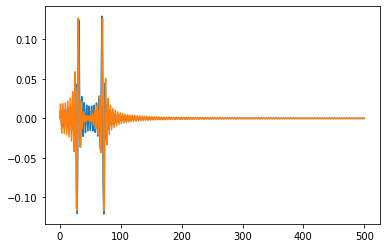

In [140]:
import matplotlib.pyplot as plt

grid_start = 0
grid_end = 1
test_grid_size = 64
field_val = 2

model_input = torch.zeros(1,grid_size,2)
model_output = torch.zeros(1,grid_size,1)

testNum = 30
model_input[:,:,:] = training_input[testNum,:,:]
model_output[:,:,:] = training_output[testNum,:,:]
#model_input = model_input.to('cuda')
input_field =  model_input[0,:,0] # training_input[10,:,0]

model_result = model(model_input)

loss = torch.nn.functional.mse_loss(model_result, model_output)
print("\r",'loss:' + str(loss.detach().cpu().numpy()), end = "")

plt.figure()
plt.plot(input_field.data)
plt.plot(model_output[0,:,0].data)
plt.plot(model_result.detach().cpu().flatten().numpy())
